In [25]:
import os
import cv2
import numpy as np
import random
import matplotlib.pyplot as plt
from DataPreparation.utils import *

# Paths
img_dir = 'Datasets/Chestxray/Test_images'
output_dir = 'Datasets/Chestxray/Output'
img_name = 'CHNCXR_0062_0.png'

df, img = load_image_and_samples(img_dir, output_dir, img_name)
node_groups = df.groupby('Node')

## Corruption

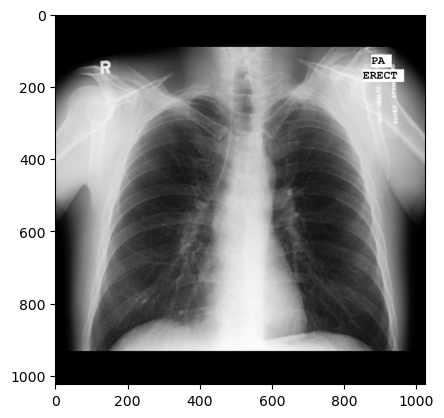

In [3]:
def sample_landmarks(landmark_dict, organ, n_samples=1):
    if landmark_dict.get(organ) is None:
        return np.empty((0,2))
    else:
        landmarks = landmark_dict[organ]
        n_samples = min(n_samples, len(landmarks))
        
        indices = np.random.choice(len(landmarks), n_samples, replace=False)

        return landmarks[indices]

np.random.seed(4)

img_name = 'MCUCXR_0022_0.png'
df, img = load_image_and_samples(img_dir, output_dir, img_name)
file_name = img_name.strip('.png')
all_landmarks = extract_landmarks(file_name, split=False)

landmarks_H = sample_landmarks(all_landmarks, 'H', n_samples=0)
landmarks_RL = sample_landmarks(all_landmarks, 'RL', n_samples=0)
landmarks_LL = sample_landmarks(all_landmarks, 'LL', n_samples=3)

landmarks = np.vstack([landmarks_H, landmarks_RL, landmarks_LL[1]]).astype(int)

corrupted_image = apply_blur(
    image=img,
    landmarks=landmarks,
    size=120,
    severity=2
)

plt.imshow(corrupted_image, cmap='gray')

In [157]:
write_path = os.path.join(img_dir, 'Corrupted', img_name.strip('.png') + f"_blur2.png")
cv2.imwrite(write_path, corrupted_image)

True

In [30]:
def gaussian_noise(image, severity):
    if severity < 1:
        return image  

    noise = np.random.normal(0, severity, image.shape).astype(np.uint8)
    noisy_image = cv2.add(image, noise) 

    return noisy_image

random.seed(42)
severity_levels = list(range(0, 20))
num_samples = 15

# Sample images from directory
all_images = [f for f in os.listdir(img_dir) if f.endswith('.png')]
selected_images = random.sample(all_images, min(num_samples, len(all_images)))

noise_dir = os.path.join(img_dir, 'Corrupted', 'noise')
os.makedirs(noise_dir, exist_ok=True)

for img_name in selected_images:
    img_path = os.path.join(img_dir, img_name)
    img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
    img_base, ext = os.path.splitext(img_name)
    
    for severity in severity_levels:
        blurred_img = gaussian_noise(img, severity)
        output_name = f"{img_base}_{severity}{ext}"
        output_path = os.path.join(noise_dir, output_name)
        
        cv2.imwrite(output_path, blurred_img)

In [29]:
def gaussian_blur(image, severity):
    if severity < 1:
        return image  
    
    kernel_size = 2*severity + 1 # Define an odd kernel size based on severity
    blurred_image = cv2.GaussianBlur(image, (kernel_size, kernel_size), 0)
    
    return blurred_image

random.seed(1)
severity_levels = list(range(0, 50, 2))
num_samples = 15

# Sample images from directory
all_images = [f for f in os.listdir(img_dir) if f.endswith('.png')]
selected_images = random.sample(all_images, min(num_samples, len(all_images)))

blurring_dir = os.path.join(img_dir, 'Corrupted', 'blurring')
os.makedirs(blurring_dir, exist_ok=True)

for img_name in selected_images:
    img_path = os.path.join(img_dir, img_name)
    img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
    img_base, ext = os.path.splitext(img_name)
    
    for severity in severity_levels:
        blurred_img = gaussian_blur(img, severity)
        output_name = f"{img_base}_{severity}{ext}"
        output_path = os.path.join(blurring_dir, output_name)
        
        cv2.imwrite(output_path, blurred_img)

In [34]:
np.random.seed(51)
occlusion_dir = os.path.join(img_dir, 'Corrupted', 'occlusion')
os.makedirs(occlusion_dir, exist_ok=True)

for img_name in selected_images:
    df, img = load_image_and_samples(img_dir, output_dir, img_name)
    file_name = img_name.strip('.png')
    all_landmarks = extract_landmarks(file_name)

    landmarks_H = sample_landmarks(all_landmarks, 'H', n_samples=0)
    landmarks_RL = sample_landmarks(all_landmarks, 'RL', n_samples=1)
    landmarks_LL = sample_landmarks(all_landmarks, 'LL', n_samples=0)

    landmarks = np.vstack([landmarks_H, landmarks_RL, landmarks_LL]).astype(int)

    corrupted_image = apply_occlusion(
        image=img,
        landmarks=landmarks,
        size=150
    )

    output_path = os.path.join(occlusion_dir, f"{file_name}_1.png")
    cv2.imwrite(output_path, corrupted_image)


## Uncertainty map

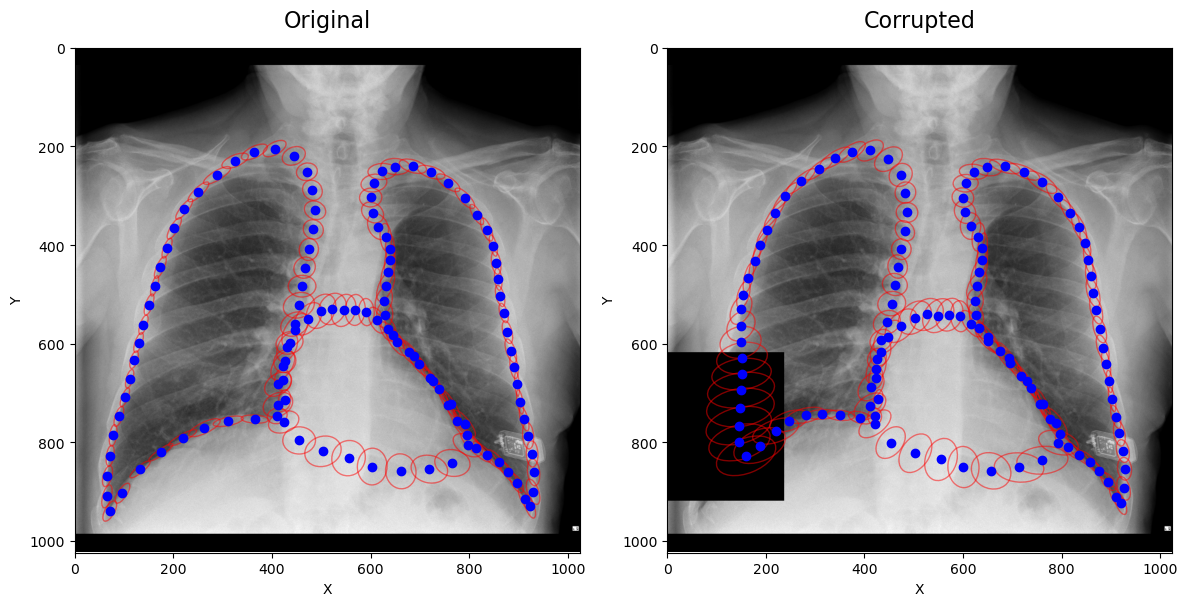

In [51]:
def compute_global_vmax(df_original, df_corrupted):
    """Compute the maximum sigma_avg across both original and corrupted datasets."""
    def calc_sigma_avg(df):
        stds = df.groupby('Node')[['X', 'Y']].std()
        return ((stds['X'] + stds['Y']) / 2).max()
    
    max_original = calc_sigma_avg(df_original)
    max_corrupted = calc_sigma_avg(df_corrupted)
    
    return max(max_original, max_corrupted)

img_dir_orig = 'Datasets/Chestxray/Test_images'
output_dir_orig = 'Datasets/Chestxray/Output'
img_dir_corr = 'Datasets/Chestxray/Test_images/Corrupted/occlusion'
output_dir_corr = 'Datasets/Chestxray/Output/Corrupted/occlusion'

img_name_orig = '121369866312829737404259612004787672904_od40ao.png'
img_name_corr = f"{img_name_orig.strip('.png')}_1.png"

df_orig, img_orig = load_image_and_samples(img_dir_orig, output_dir_orig, img_name_orig)
df_corr, img_corr = load_image_and_samples(img_dir_corr, output_dir_corr, img_name_corr)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))

plot_mean_with_uncertainty(df_orig, use_error_bars=False, scale_factor=8, img=img_orig, fig=fig, ax=ax1)
plot_mean_with_uncertainty(df_corr, use_error_bars=False, scale_factor=8, img=img_corr, fig=fig, ax=ax2)

ax1.set_title('Original', fontsize=16, pad=15)
ax2.set_title('Corrupted', fontsize=16, pad=15)

plt.tight_layout()
plt.show()


/tmp/ipykernel_35736/4004267365.py:23: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


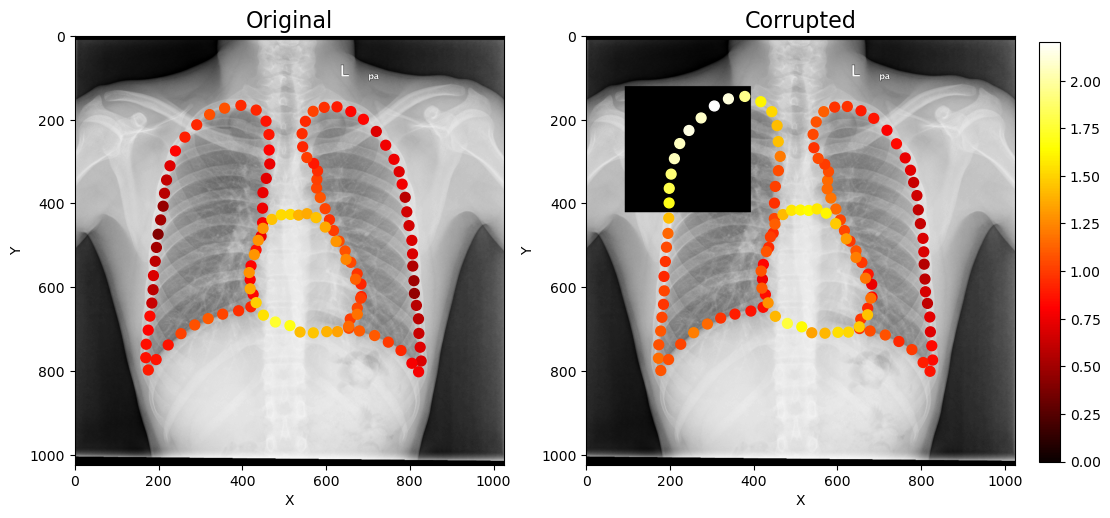

In [42]:
img_name_orig = 'CHNCXR_0304_0.png'
img_name_corr = f"{img_name_orig.strip('.png')}_1.png"

df_orig, img_orig = load_image_and_samples(img_dir_orig, output_dir_orig, img_name_orig)
df_corr, img_corr = load_image_and_samples(img_dir_corr, output_dir_corr, img_name_corr)

vmax = compute_global_vmax(df_orig, df_corr)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))

# Plot first subplot (Original) without colorbar
fig, ax1, scatter1 = plot_mean_with_color_gradient(df_orig, img=img_orig, fig=fig, ax=ax1, show_bar=False, vmax=vmax)
ax1.set_title('Original', fontsize=16)

# Plot second subplot (Corrupted) without colorbar
fig, ax2, scatter2 = plot_mean_with_color_gradient(df_corr, img=img_corr, fig=fig, ax=ax2, show_bar=False, vmax=vmax)
ax2.set_title('Corrupted', fontsize=16)

# Add a single shared colorbar outside to the right
cbar = fig.colorbar(scatter1, ax=[ax1, ax2], orientation='vertical', fraction=0.05)

# Adjust layout to ensure colorbar is outside both plots
plt.tight_layout()
plt.subplots_adjust(right=0.85)  # Leave space on the right for the colorbar
cbar.ax.set_position([0.87, 0.15, 0.03, 0.7])  # [left, bottom, width, height] in figure coordinates

plt.show()

/tmp/ipykernel_34217/2015019434.py:23: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


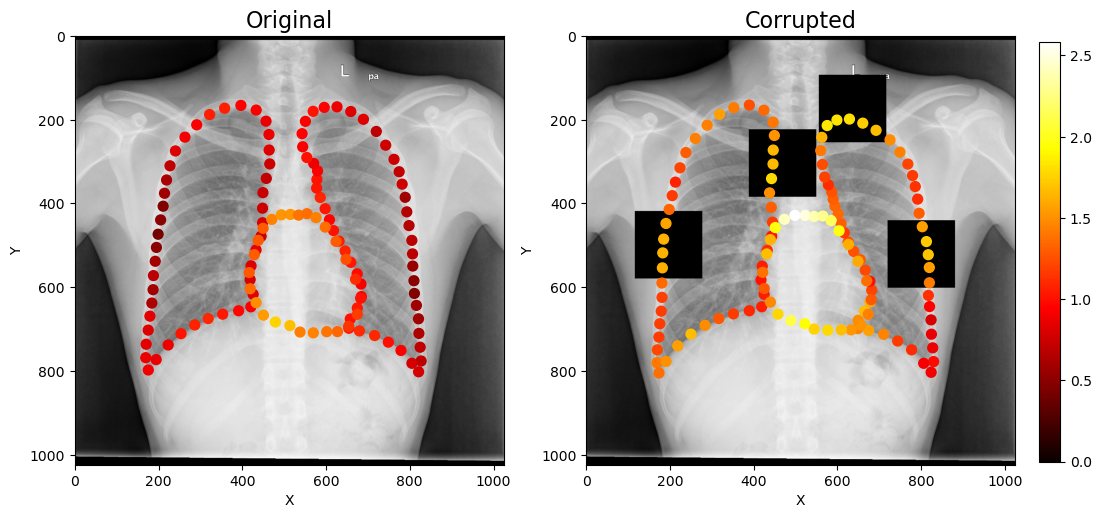

In [15]:
img_name_orig = 'CHNCXR_0304_0.png'
img_name_corr = f"{img_name_orig.strip('.png')}_4.png"

df_orig, img_orig = load_image_and_samples(img_dir_orig, output_dir_orig, img_name_orig)
df_corr, img_corr = load_image_and_samples(img_dir_corr, output_dir_corr, img_name_corr)

vmax = compute_global_vmax(df_orig, df_corr)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))

# Plot first subplot (Original) without colorbar
fig, ax1, scatter1 = plot_mean_with_color_gradient(df_orig, img=img_orig, fig=fig, ax=ax1, show_bar=False, vmax=vmax)
ax1.set_title('Original', fontsize=16)

# Plot second subplot (Corrupted) without colorbar
fig, ax2, scatter2 = plot_mean_with_color_gradient(df_corr, img=img_corr, fig=fig, ax=ax2, show_bar=False, vmax=vmax)
ax2.set_title('Corrupted', fontsize=16)

# Add a single shared colorbar outside to the right
cbar = fig.colorbar(scatter1, ax=[ax1, ax2], orientation='vertical', fraction=0.05)

# Adjust layout to ensure colorbar is outside both plots
plt.tight_layout()
plt.subplots_adjust(right=0.85)  # Leave space on the right for the colorbar
cbar.ax.set_position([0.87, 0.15, 0.03, 0.7])  # [left, bottom, width, height] in figure coordinates

plt.show()

/tmp/ipykernel_34217/373939330.py:23: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


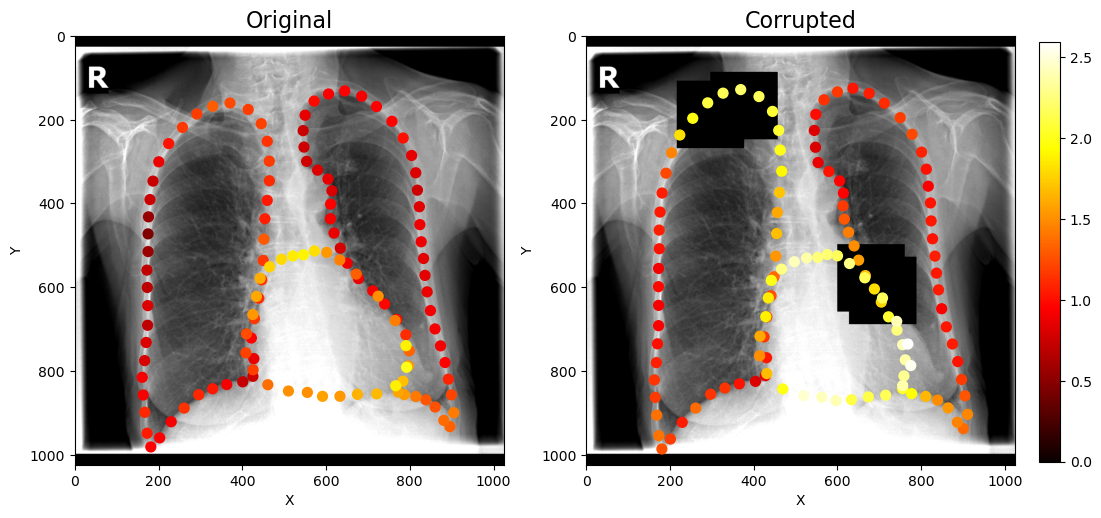

In [14]:
img_name_orig = '245895219126534788779109786698958326807_1a9ait.png'
img_name_corr = f"{img_name_orig.strip('.png')}_4.png"

df_orig, img_orig = load_image_and_samples(img_dir_orig, output_dir_orig, img_name_orig)
df_corr, img_corr = load_image_and_samples(img_dir_corr, output_dir_corr, img_name_corr)

vmax = compute_global_vmax(df_orig, df_corr)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))

# Plot first subplot (Original) without colorbar
fig, ax1, scatter1 = plot_mean_with_color_gradient(df_orig, img=img_orig, fig=fig, ax=ax1, show_bar=False, vmax=vmax)
ax1.set_title('Original', fontsize=16)

# Plot second subplot (Corrupted) without colorbar
fig, ax2, scatter2 = plot_mean_with_color_gradient(df_corr, img=img_corr, fig=fig, ax=ax2, show_bar=False, vmax=vmax)
ax2.set_title('Corrupted', fontsize=16)

# Add a single shared colorbar outside to the right
cbar = fig.colorbar(scatter1, ax=[ax1, ax2], orientation='vertical', fraction=0.05)

# Adjust layout to ensure colorbar is outside both plots
plt.tight_layout()
plt.subplots_adjust(right=0.85)  # Leave space on the right for the colorbar
cbar.ax.set_position([0.87, 0.15, 0.03, 0.7])  # [left, bottom, width, height] in figure coordinates

plt.show()

/tmp/ipykernel_80057/2623752274.py:25: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


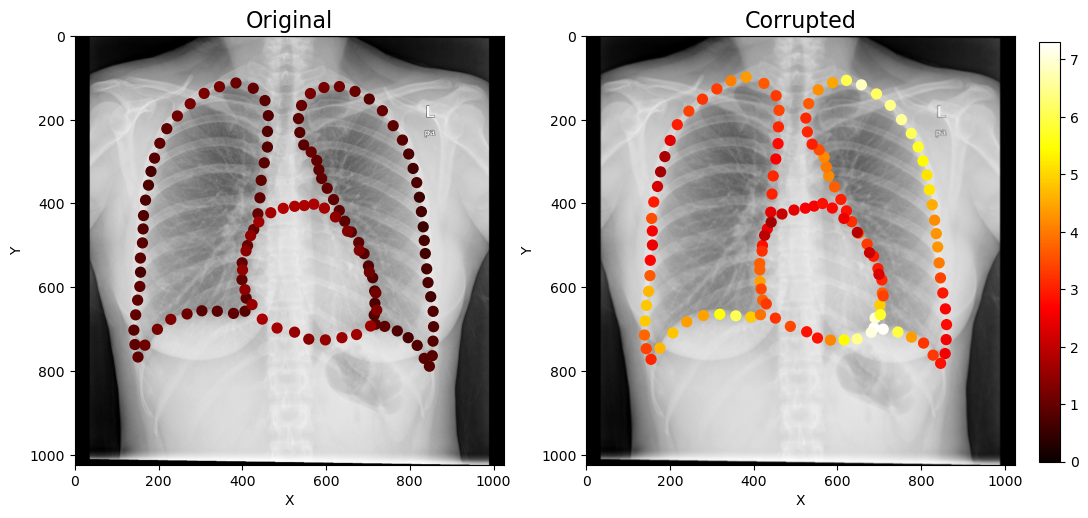

In [91]:
img_dir_corr = 'Datasets/Chestxray/Test_images/Corrupted/blurring'
output_dir_corr = 'Datasets/Chestxray/Output/Corrupted/blurring'
img_name_orig = 'CHNCXR_0084_0.png'
img_name_corr = f"{img_name_orig.strip('.png')}_2.png"

df_orig, img_orig = load_image_and_samples(img_dir_orig, output_dir_orig, img_name_orig)
df_corr, img_corr = load_image_and_samples(img_dir_corr, output_dir_corr, img_name_corr)

vmax = compute_global_vmax(df_orig, df_corr)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))

# Plot original img
fig, ax1, scatter1 = plot_mean_with_color_gradient(df_orig, img=img_orig, fig=fig, ax=ax1, show_bar=False, vmax=vmax)
ax1.set_title('Original', fontsize=16)

# Plot corrupted
fig, ax2, scatter2 = plot_mean_with_color_gradient(df_corr, img=img_corr, fig=fig, ax=ax2, show_bar=False, vmax=vmax)
ax2.set_title('Corrupted', fontsize=16)

# Add a single shared colorbar outside to the right
cbar = fig.colorbar(scatter1, ax=[ax1, ax2], orientation='vertical', fraction=0.05)

# Adjust layout to ensure colorbar is outside both plots
plt.tight_layout()
plt.subplots_adjust(right=0.85)  
cbar.ax.set_position([0.87, 0.15, 0.03, 0.7]) 

plt.show()

## Noise vs uncertainty

In [ ]:
img_dir_noise = os.path.join(img_dir, 'Corrupted', 'noise')
output_dir_noise = os.path.join(output_dir, 'Corrupted', 'noise')
selected_images = {
    "_".join(file.split('_')[:-1]) + ".png"
    for file in os.listdir(img_dir_noise)
}

sigma_dict = process_corr_images(img_dir_noise, output_dir_noise, selected_images)

img_dir_blur = os.path.join(img_dir, 'Corrupted', 'blurring')
output_dir_blur = os.path.join(output_dir, 'Corrupted', 'blurring')
selected_images = {
    "_".join(file.split('_')[:-1]) + ".png"
    for file in os.listdir(img_dir_blur)
}

sigma_dict = process_corr_images(img_dir_blur, output_dir_blur, selected_images)

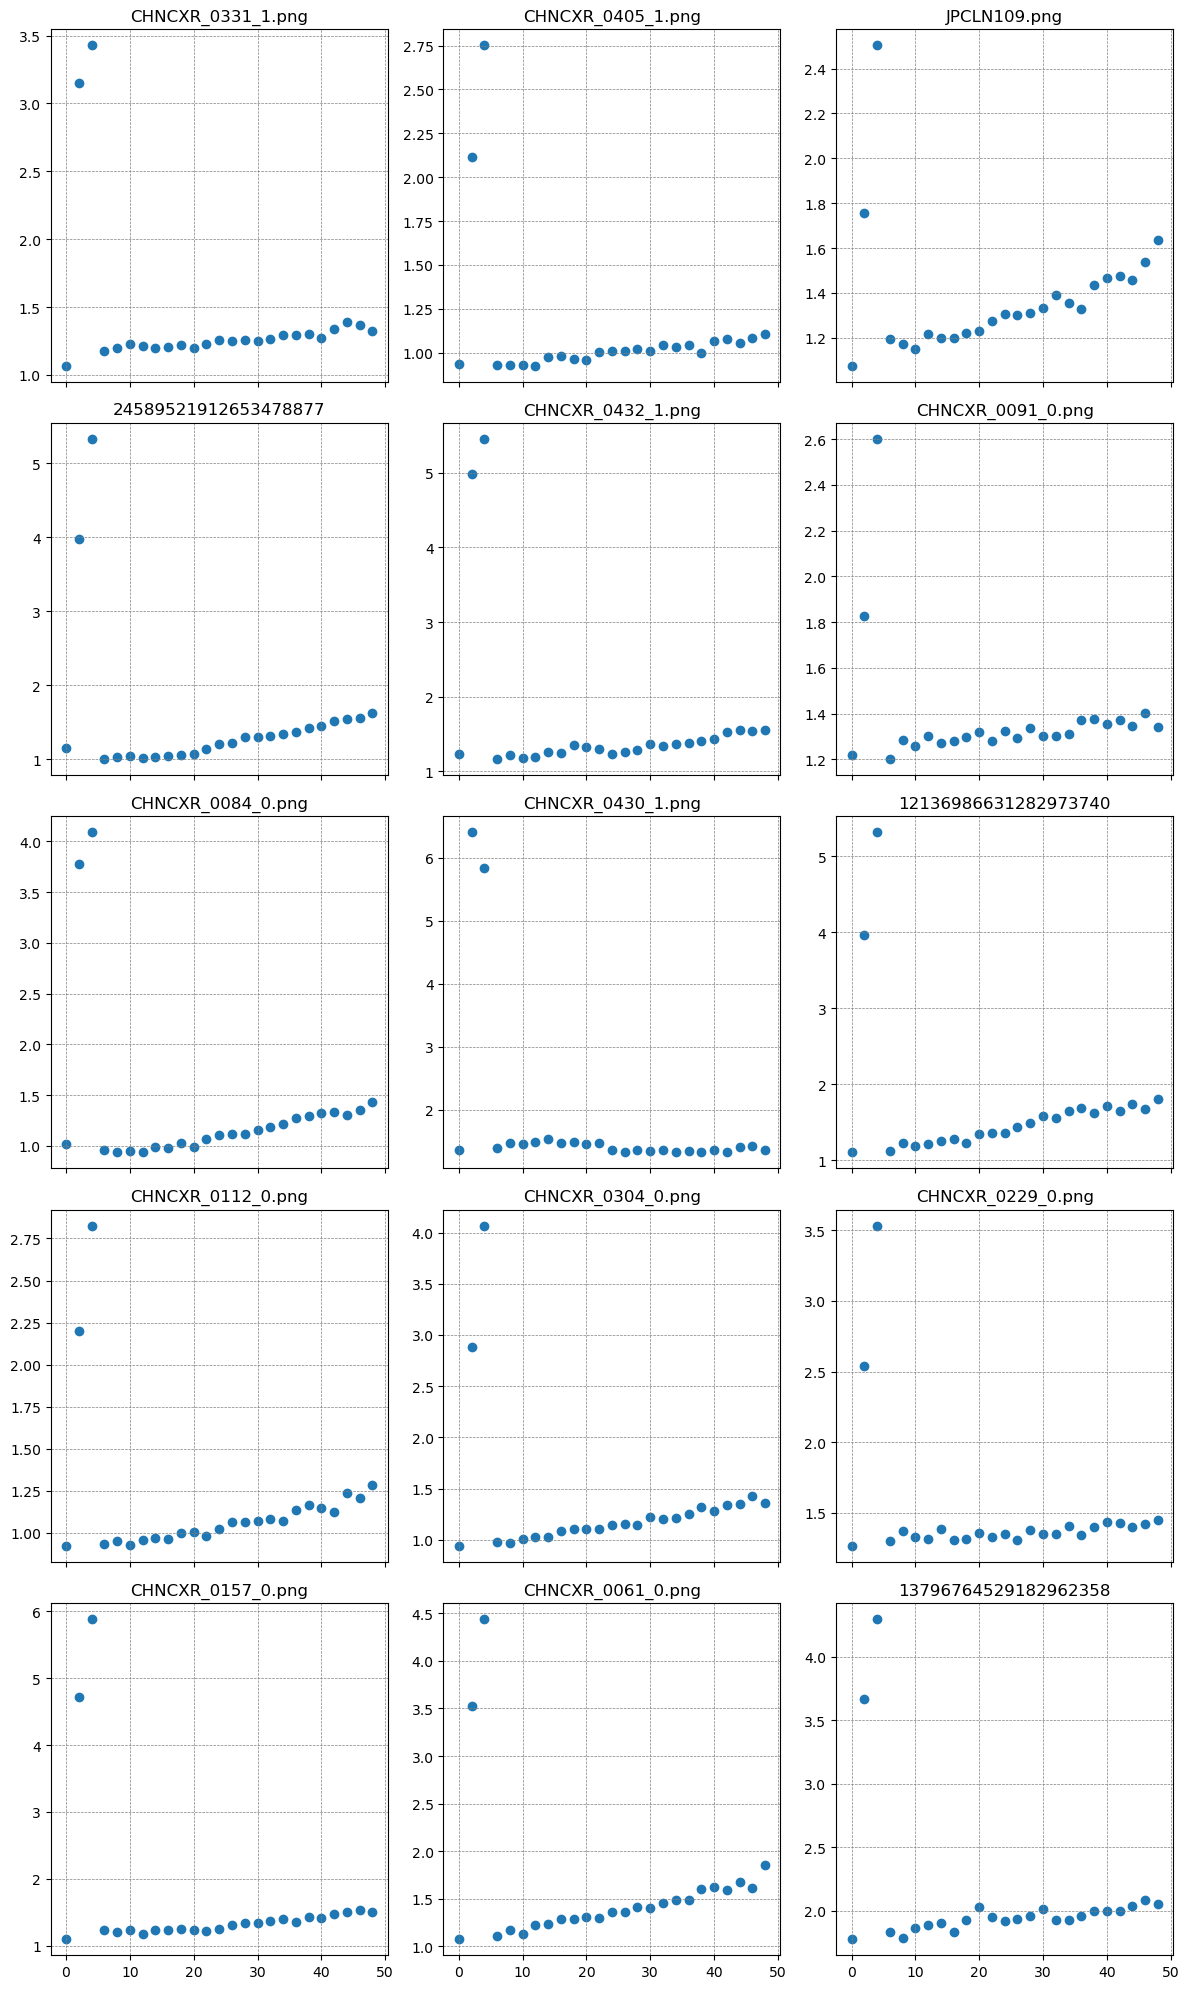

In [ ]:
n_images = len(sigma_dict)
n_cols = 3
n_rows = (n_images + n_cols - 1) // n_cols  

fig, axes = plt.subplots(n_rows, n_cols, figsize=(12, 4 * n_rows), sharex=True)

axes = axes.flatten()

for i, (img_name, vals) in enumerate(sigma_dict.items()):
    ax = axes[i]
    
    # Extract corr_levels and sigma_avgs
    corr_levels = vals['corr_levels']
    sigma_avgs = vals['sigma_avgs']
    
    ax.scatter(corr_levels, sigma_avgs)
    ax.set_title(img_name[:20])
    ax.grid(True, color='gray', linestyle='--', linewidth=0.5)

plt.tight_layout()
plt.show()

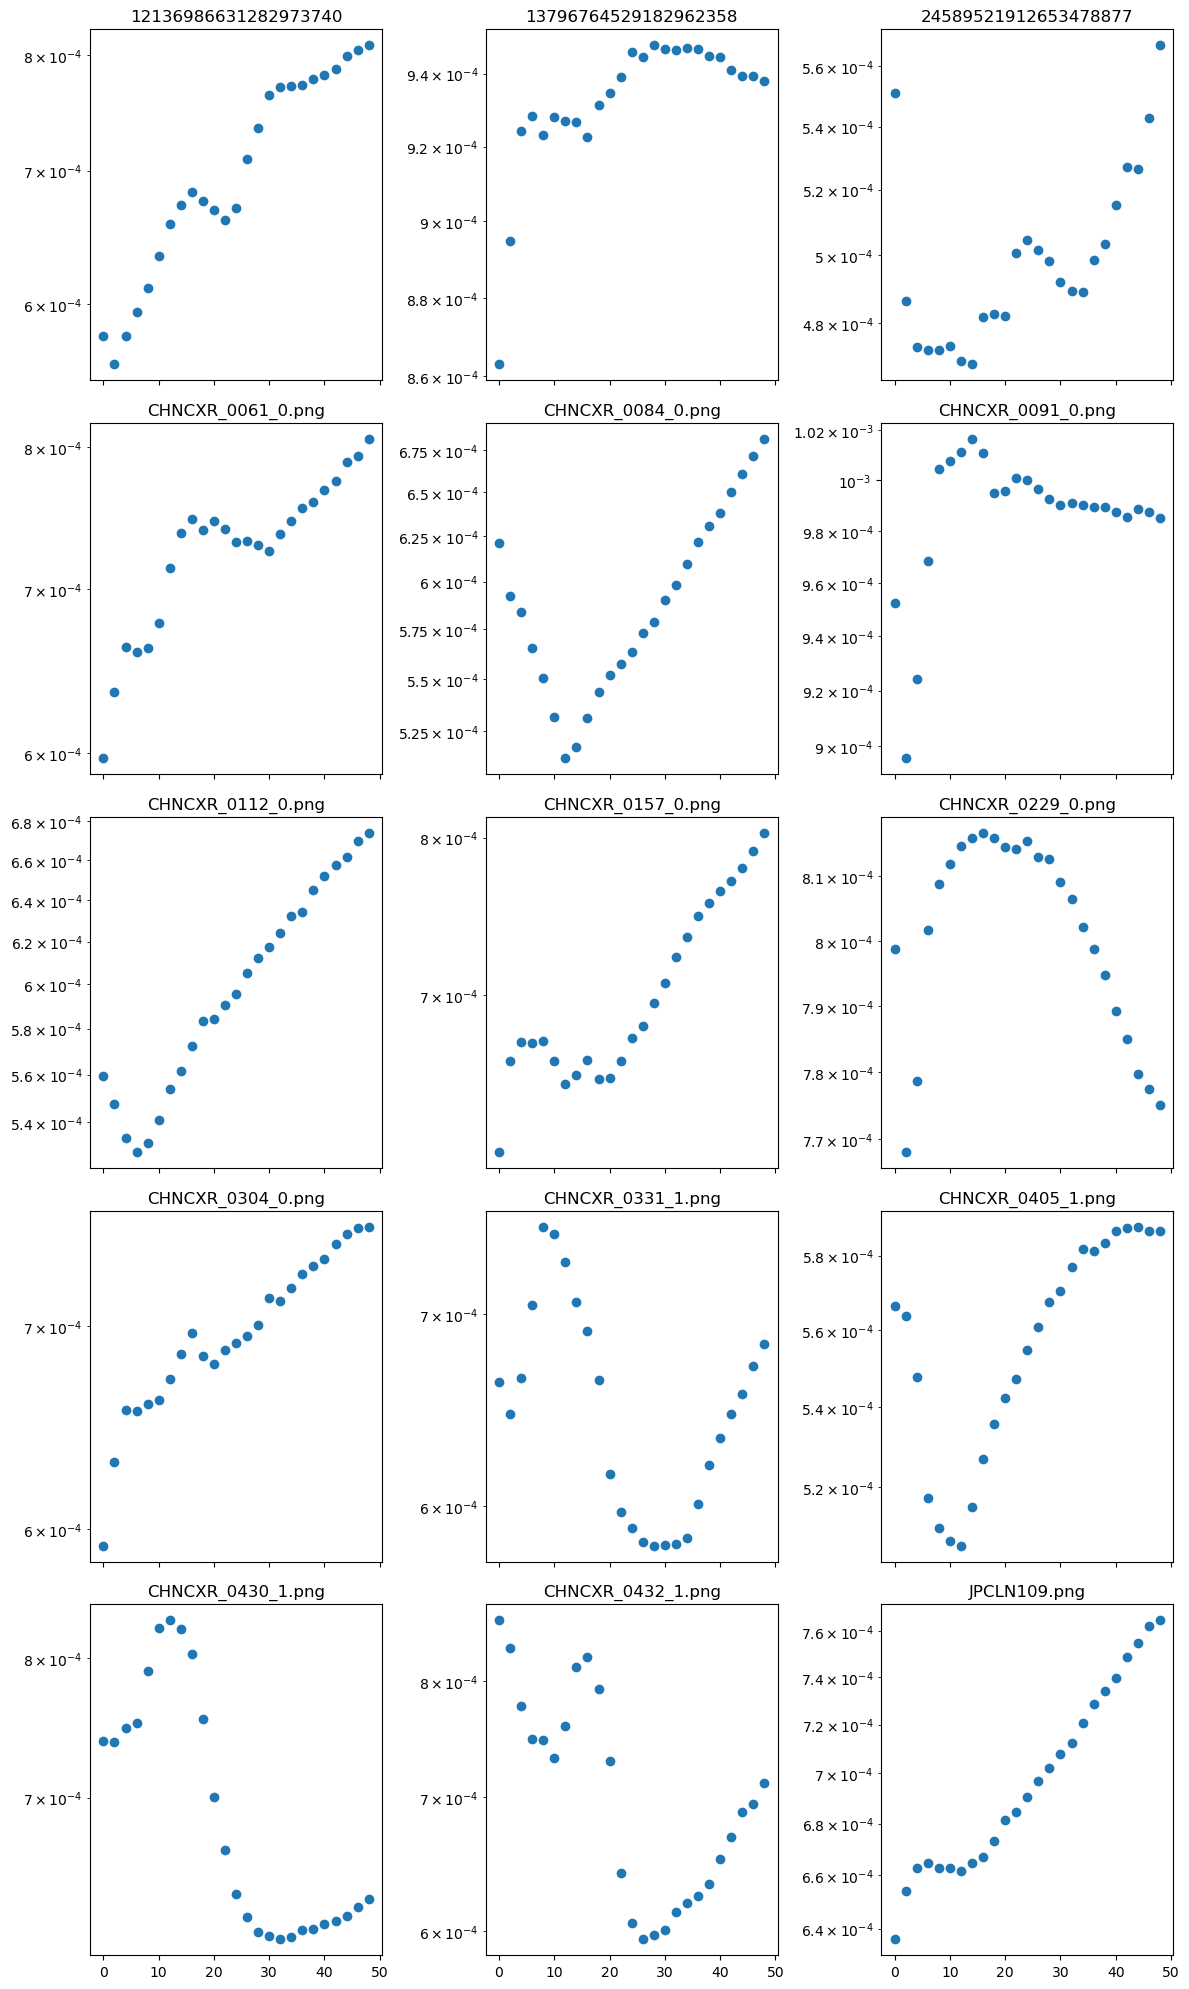

In [46]:
file_path = 'Datasets/Chestxray/sigmas_blurring.txt'

latent_sigma_dict = read_sigma_file(file_path)

n_images = len(latent_sigma_dict)
n_cols = 3
n_rows = (n_images + n_cols - 1) // n_cols  

fig, axes = plt.subplots(n_rows, n_cols, figsize=(12, 4 * n_rows), sharex=True)

axes = axes.flatten()

for i, (img_name, vals) in enumerate(latent_sigma_dict.items()):
    ax = axes[i]
    
    # Extract corr_levels and sigma_avgs
    corr_levels = vals['corr_levels']
    sigma_avgs = vals['sigma_avgs']
    
    ax.scatter(corr_levels, sigma_avgs)
    ax.set_title(img_name[:20])
    ax.set_yscale('log')
    #ax.grid(True, which='both', color='gray', linestyle='--', linewidth=0.5)

plt.tight_layout()
plt.show()

## Error vs uncertainty

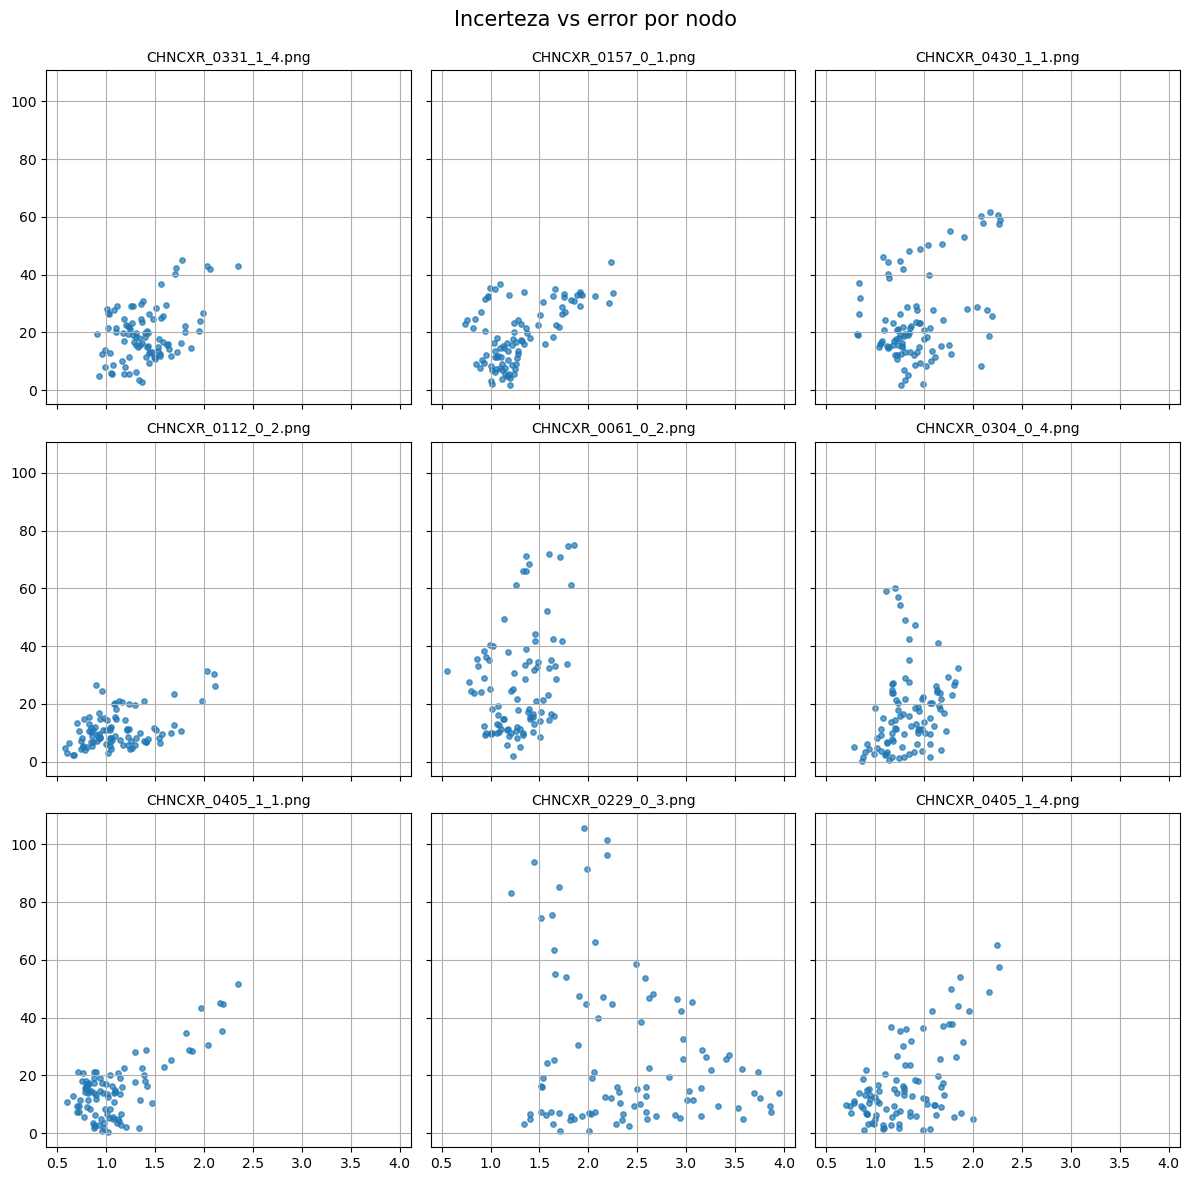

In [35]:
img_dir_occ = os.path.join(img_dir, 'Corrupted', 'occlusion')
output_dir_occ = os.path.join(output_dir, 'Corrupted', 'occlusion')
files = os.listdir(img_dir_occ)

img_dict_occ, img_dict_orig = {}, {}

for file in files:
    error, sigmas = get_error(img_dir_occ, output_dir_occ, file)
    img_dict_occ[file] = (error, sigmas)

all_err = []
all_sigmas = []

for error, sigmas in img_dict_occ.values():
    all_err.extend(error)       
    all_sigmas.extend(sigmas)

fig, axes = plt.subplots(3, 3, figsize=(12, 12), sharex=True, sharey=True)
axes = axes.flatten()

for i, key in enumerate(list(img_dict_occ.keys())[:9]):
    error, sigmas = img_dict_occ[key]  
    
    ax = axes[i]  
    ax.scatter(sigmas, error, s=15, alpha=0.7)  
    ax.set_title(key, fontsize=10)
    ax.grid(True)

plt.tight_layout()
plt.suptitle('Incerteza vs error por nodo', fontsize=15)
plt.subplots_adjust(top=0.93) 
plt.show()

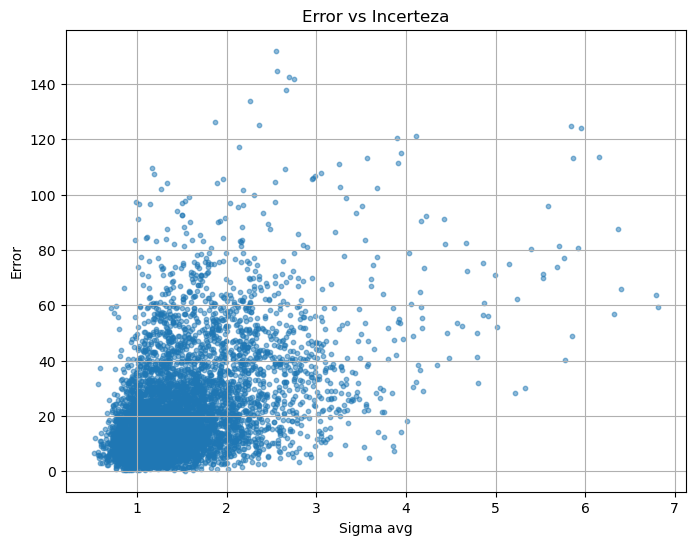

In [15]:
plt.figure(figsize=(8, 6))
plt.scatter(all_sigmas, all_err, alpha=0.5, s=10) 
plt.xlabel("Sigma avg")
plt.ylabel("Error")
plt.title("Error vs Incerteza")
plt.grid(True)
plt.show()

In [ ]:
img_name = 'CHNCXR_0091_0_1.png'

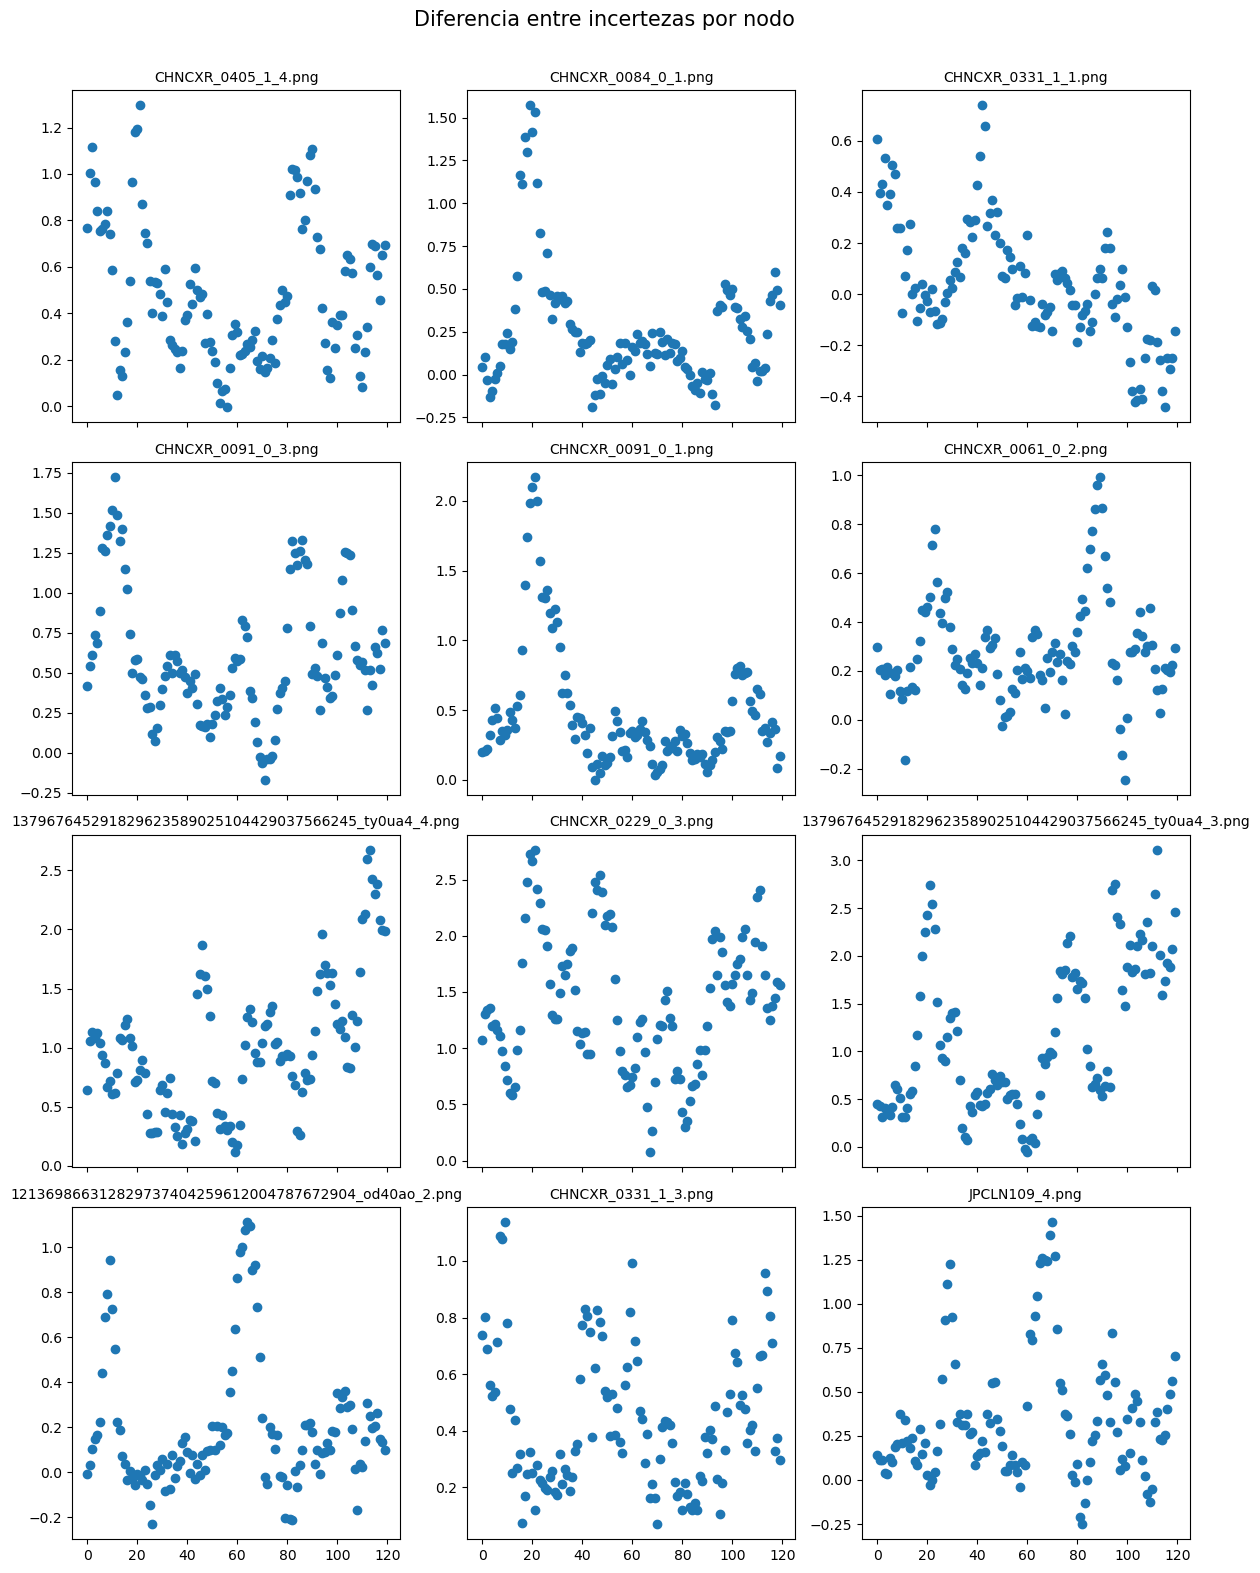

In [87]:
import random

def find_std(img_dir, output_dir, img_file):
    df, _ = load_image_and_samples(img_dir, output_dir, img_file)
    node_groups = df.groupby('Node')
    stds = node_groups[['X', 'Y']].std()
    sigma = (stds['X'] + stds['Y']) / 2

    return sigma

random.seed(1)
N_samples = 12

occlusion_dir = os.path.join(img_dir, 'Corrupted', 'occlusion')
output_dir_occ = os.path.join(output_dir, 'Corrupted', 'occlusion')
occl_files = os.listdir(occlusion_dir)
occl_files = random.sample(occl_files, N_samples)
occl_basenames = [fname.rsplit('_', 1)[0] for fname in occl_files]
img_files = [next(f for f in os.listdir(img_dir) if f.startswith(base)) for base in occl_basenames]

n_rows, n_cols = 4, 3
fig, axes = plt.subplots(n_rows, n_cols, figsize=(12, 4 * n_rows), sharex=True)
axes = axes.flatten()

for i,file in enumerate(occl_files):
    img_file = next(f for f in img_files if f.startswith(file.rsplit('_', 1)[0]))
    
    std_orig = find_std(img_dir, output_dir, img_file)
    std_corr = find_std(occlusion_dir, output_dir_occ, file)
    std_diff = std_corr - std_orig

    axes[i].scatter(np.arange(len(std_diff)), std_diff)
    axes[i].set_title(file, fontsize=10)

plt.tight_layout()
plt.suptitle('Diferencia entre incertezas por nodo', fontsize=15)
plt.subplots_adjust(top=0.93) 
plt.show()